# Spam/Ham Classification


## PART-I
## Introduction
### Data Loading, Feature Engineering, Logistic Regression

In this project, I will apply the following techniques to create a classifier that can distinguish spam (junk or comercial or buil) emails from ham (non-spam) emails:
* Data Loading using pandas
* Feature Engineering with text data
* Using sklearn libraries to process data and fit models
* Evaluting the model

# Outline of the Project

1. [Introduction](#PART-I)
2. [Data Loading](#PART-II)
3. [Feature Engineering](#PART-III)
4. [Model Building](#PART-IV)
5. [Model Evaluation](#PART-V)
6. [Next Step](#PART-VI)

In [2]:
import numpy as np
import pandas as pd
import bs4 as bs

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

In [3]:
import re
import hashlib
 
# download NLTK classifiers - these are cached locally on your machine
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

# import ml classifiers
from nltk.tokenize import sent_tokenize # tokenizes sentences
from nltk.stem import PorterStemmer     # parsing/stemmer
from nltk.tag import pos_tag            # parts-of-speech tagging
from nltk.corpus import wordnet         # sentiment scores
from nltk.stem import WordNetLemmatizer # stem and context
from nltk.corpus import stopwords       # stopwords
from nltk.util import ngrams            # ngram iterator

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/wantinglu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/wantinglu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wantinglu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/wantinglu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer

## PART-II
### Loading in the Data

In email classification, my goal is to classify emails as spam or not spam (referred to as "ham") using features generated from the te4xt in the email.

The dataset consists of email messeges and their labels (0 for ham, 1 for spam). The labeled training dataset contains 8348 labeled examples.

Running the follwing cells will load in the data into DataFrames.

The `train` DataFrame contains labeled data that I will use to train my model. It contains four columns: 
1. `id`: An identifier for the training example
1. `subject`: The subject of the email
1. `email`: The text of the email
1. `spam`: 1 if the email is spam, 0 if the email is ham (not spam)


In [177]:
train_orig=pd.read_csv("train.csv")
train_orig.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,URL: http://boingboing.net/#85534171\n Date: N...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",URL: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<HTML>\n <HEAD>\n </HEAD>\n <BODY>\n <FONT SIZ...,1
3,3,Subject: liberal defnitions\n,Depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


In [178]:
## convert the emails to lower case
train_orig['email']=train_orig['email'].str.lower()
train_orig.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


First, let's check if the data contains any missing values. If there are NaN values, replace them with appropriate filler values (i.e., NaN values in the `subject` or `email` columns should be replaced with empty strings). Print the number of NaN values in each column after this modification to verify that there are no NaN values left.

Note that while there are no NaN values in the `spam` column, we should be careful when replacing NaN labels. Doing so without consideration may introduce significant bias into our model when fitting.

In [179]:
is_null_orig=train_orig.isnull().sum()
print(is_null_orig)
train_orig=train_orig.fillna('')
is_null_new=train_orig.isnull().sum()
print(is_null_new)
train_orig.head()

id         0
subject    6
email      0
spam       0
dtype: int64
id         0
subject    0
email      0
spam       0
dtype: int64


,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


In the cell below, let's print the text of the first ham and the first spam email in the original training set.

In [8]:
first_ham = train_orig[train_orig['spam'] == 0].iloc[0, 2]
first_spam = train_orig[train_orig['spam'] == 1].iloc[0, 2]
print(first_ham)
print('-----------')
print(first_spam)

url: http://boingboing.net/#85534171
 date: not supplied
 
 arts and letters daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. a&l daily will be auctioned off by the 
 receivers. link[1] discuss[2] (_thanks, misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf
 
 

-----------
<html>
 <head>
 </head>
 <body>
 <font size=3d"4"><b> a man endowed with a 7-8" hammer is simply<br>
  better equipped than a man with a 5-6"hammer. <br>
 <br>would you rather have<br>more than enough to get the job done or fall =
 short. it's totally up<br>to you. our methods are guaranteed to increase y=
 our size by 1-3"<br> <a href=3d"http://209.163.187.47/cgi-bin/index.php?10=
 004">come in here and see how</a>
 </body>
 </html>
 
 
 



## PART-III

### Feature Engineering

Define a function called `plain_text`, which does the following works:

> - Removes HTML tags (using beautifulsoup)
> - Extract emoticons (emotion symbols, aka smileys :D )
> - Removes non-letters (using regular expression)
> - Converts all words to lowercase letters and tokenizes them (using .split() method on the email strings, so that every word in the email is an element in a list)
> - Removes all the English stopwords from the list of email texts
> - Applies either stemming or lemmatization, as indicated by the arguments
> - Join the words back into one string seperated by space, append the emoticons to the end

In [9]:
ps = PorterStemmer()
wnl = WordNetLemmatizer()
eng_stopwords = set(stopwords.words("english"))

def plain_text(email, lemmatize=True, stem=False):
    '''
        Clean and preprocess an email.
            1. Remove HTML tags
            2. Extract emoticons
            3. Use regex to remove all special characters (only keep letters)
            4. Make strings to lower case and tokenize / word split email
            5. Remove English stopwords
            6. Lemmatize
            7. Rejoin to one string
        
        @email (type:str) is an unprocessed email string
        @return (type:str) is a 6-step preprocessed email string
    '''

    

    if lemmatize == True and stem == True:
        raise RuntimeError("May not pass both lemmatize and stem flags")

    #1. Remove HTML tags
    email = bs.BeautifulSoup(email).text    

    #2. Use regex to find emoticons
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', email)

    #3. Remove punctuation
    email = re.sub("[^a-zA-Z]", " ",email)

    #4. Tokenize into words (all lower case)
    email = email.lower().split()

    #5. Remove stopwords, Lemmatize, Stem
    clean_email=[]
    for word in email:
        if word not in eng_stopwords:
            if lemmatize is True:
                word=wnl.lemmatize(word)
            elif stem is True:
                if word == 'oed':
                    continue
                word=ps.stem(word)
            clean_email.append(word)

    #6. Join the review to one sentence
    email_processed = ' '.join(clean_email+emoticons)
    
    return email_processed

In [180]:
train_orig['plain_text']=np.zeros(len(train_orig))
for i in range(len(train_orig)):
    train_orig['plain_text'][i]=plain_text(train_orig['email'][i])


<ipython-input-180-4ee3f4df0380>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_orig['plain_text'][i]=plain_text(train_orig['email'][i])
/Users/wantinglu/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [181]:
train_orig['plain_subject']=np.zeros(len(train_orig))
for i in range(len(train_orig)):
    train_orig['plain_subject'][i]=plain_text(train_orig['subject'][i])


<ipython-input-181-d190b0670e96>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_orig['plain_subject'][i]=plain_text(train_orig['subject'][i])


let's print out a clean email text and the subject

In [187]:
print('original text: \n', train_orig['email'][0])
print('===================')
print('clean text: \n', train_orig['plain_text'][0])


original text: 
 url: http://boingboing.net/#85534171
 date: not supplied
 
 arts and letters daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. a&l daily will be auctioned off by the 
 receivers. link[1] discuss[2] (_thanks, misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf
 
 

clean text: 
 url http boingboing net date supplied art letter daily wonderful dense blog folded tent due bankruptcy parent company l daily auctioned receiver link discus thanks misha http www aldaily com http www quicktopic com boing h zlfterjnd jf


In [188]:
print('original subject: \n', train_orig['subject'][0])
print('===================')
print('clean subject: \n', train_orig['plain_subject'][0])

original subject: 
 Subject: A&L Daily to be auctioned in bankruptcy

clean subject: 
 subject l daily auctioned bankruptcy


#### Feature one: the length of the email text

Create a *class conditional density plot* (using `sns.distplot`), comparing the distribution of the length of spam emails to the distribution of the length of ham emails in the training set. Set the x-axis limit from 0 to 50000.

As we can see that ham emails tend to have shorter length in the email body text.

/Users/wantinglu/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/wantinglu/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'the Length Distribution of Spam/Ham Email Body')

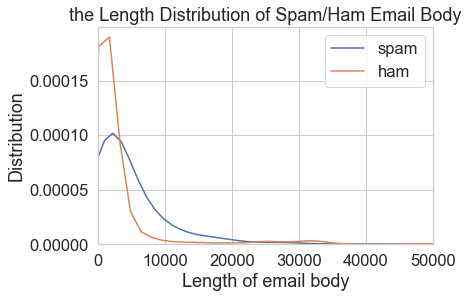

In [13]:
## Creat a class confitional desity plot comparing the distribution
## of the length of spam emails to the distribution of the length
## of the ham emails in the training set

sns.distplot([len(train_orig[train_orig['spam'] == 1].iloc[i, 2]) for i in range(len(train_orig[train_orig['spam'] == 1]))], hist=False, label = 'spam')
sns.distplot([len(train_orig[train_orig['spam'] == 0].iloc[i, 2]) for i in range(len(train_orig[train_orig['spam'] == 0]))], hist = False, label = 'ham')
plt.xlim(0, 50000)
plt.xlabel('Length of email body')
plt.ylabel('Distribution')
plt.legend()
plt.title('the Length Distribution of Spam/Ham Email Body')

#### Other Features relatied to the Lengths

* `sub_length`: returns the length of the subject after cleaning.
* `text_length`: returns the length of the email body after cleaning.

I also created a function call `word_count` which takes in a series, and returns the list of word counts of the given series.
* `sub_wordcount`: returns the counts of the words of the subject.
* `email_wordcount`: returns the counts of the words of the email text.

In [232]:
train_orig['sub_length']=train_orig['plain_subject'].str.len()
train_orig['text_length']=train_orig['plain_text'].str.len()

In [233]:
def word_count(series):
    lenlist=[]
    for i in range(len(series)):
        lenlist.append(len(series[i].split()))
    return lenlist
        
      

In [234]:
train_orig['sub_wordcount']=word_count(train_orig['plain_subject'])
train_orig['email_wordcount']=word_count(train_orig['plain_text'])

#### A binary feature: Reply

* `reply`: return either 0 (the email is a reply email) or 1.

In [231]:
train_orig['reply']=words_in_texts(['Re:'], train_orig['subject'])

#### Other binary features created from the email body

Recall that to train an logistic regression model we need a numeric feature matrix X and a vector of corresponding binary labels _y_. So after some text cleaning, I need to transfer the text data into some numeric features in order to use logistic regression to train a classifier. 

Each row of X is an email. Each column of X contains one feature of all the emails. 

I created the below function called `words_in_texts` that takes in a list of `words` and a pandas Series of email `texts`. It should output a 2-dimensional NumPy array containing one row for each email text. The row should contain either a 0 or a 1 for each word in the list: 0 if the word doesn't appear in the text and 1 if the word does. For example:

```
>>> words_in_texts(['hello', 'bye', 'world'], 
                   pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])
```

In [12]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list-like): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    result = np.array([[0]*len(words)]*len(texts))
#transfer the result to an array
    for i in range(len(texts)):
        for j in range(len(words)):
            if words[j] in texts[i]:
                result[i][j] = 1
    indicator_array = result
    return np.array(indicator_array)

words_in_texts(['hello', 'bye', 'world'], 
                   pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])

A function called `word_freq` was created to count the frequency of each words in order to find the most frequent words occur in the spam emails.

In [236]:
def word_freq(s):
    counts=dict()
    words=s.split()

    for word in words:

        if word in counts:

            counts[word] += 1
        else:
            counts[word] = 1
    return counts

In [237]:
spam_email=""
ham_email=""
for i in range(len(train_orig['plain_text'])):
    if train_orig['spam'][i]==0:
        ham_email += train_orig['plain_text'][i]
    else:
        spam_email += train_orig['plain_text'][i]

spam_count=word_freq(spam_email)
ham_count=word_freq(ham_email)

w=[]
c=[]
for word in spam_count:
    if word in ham_count and len(word)>3:
        w.append(word)
        c.append(spam_count[word]-ham_count[word])

freq_word=pd.DataFrame(c, index=w)

In [238]:
words1=freq_word.sort_values(by=0, ascending=False).head(30).index
words1

Index(['money', 'order', 'free', 'receive', 'email', 'please', 'business',
       'name', 'grant', 'address', 'offer', 'report', 'credit', 'removed',
       'insurance', 'nbsp', 'nextpart', 'marketing', 'program', 'remove',
       'wish', 'reply', 'dollar', 'face', 'guide', 'cash', 'send', 'form',
       'fill', 'color'],
      dtype='object')

Created a bar chart like the one above comparing the proportion of spam and ham emails containing certain words. I chose the set of words based on the `freq_word` given from  above.

Text(0.5, 1.0, 'Frequency of Words in Spam/Ham Emails')

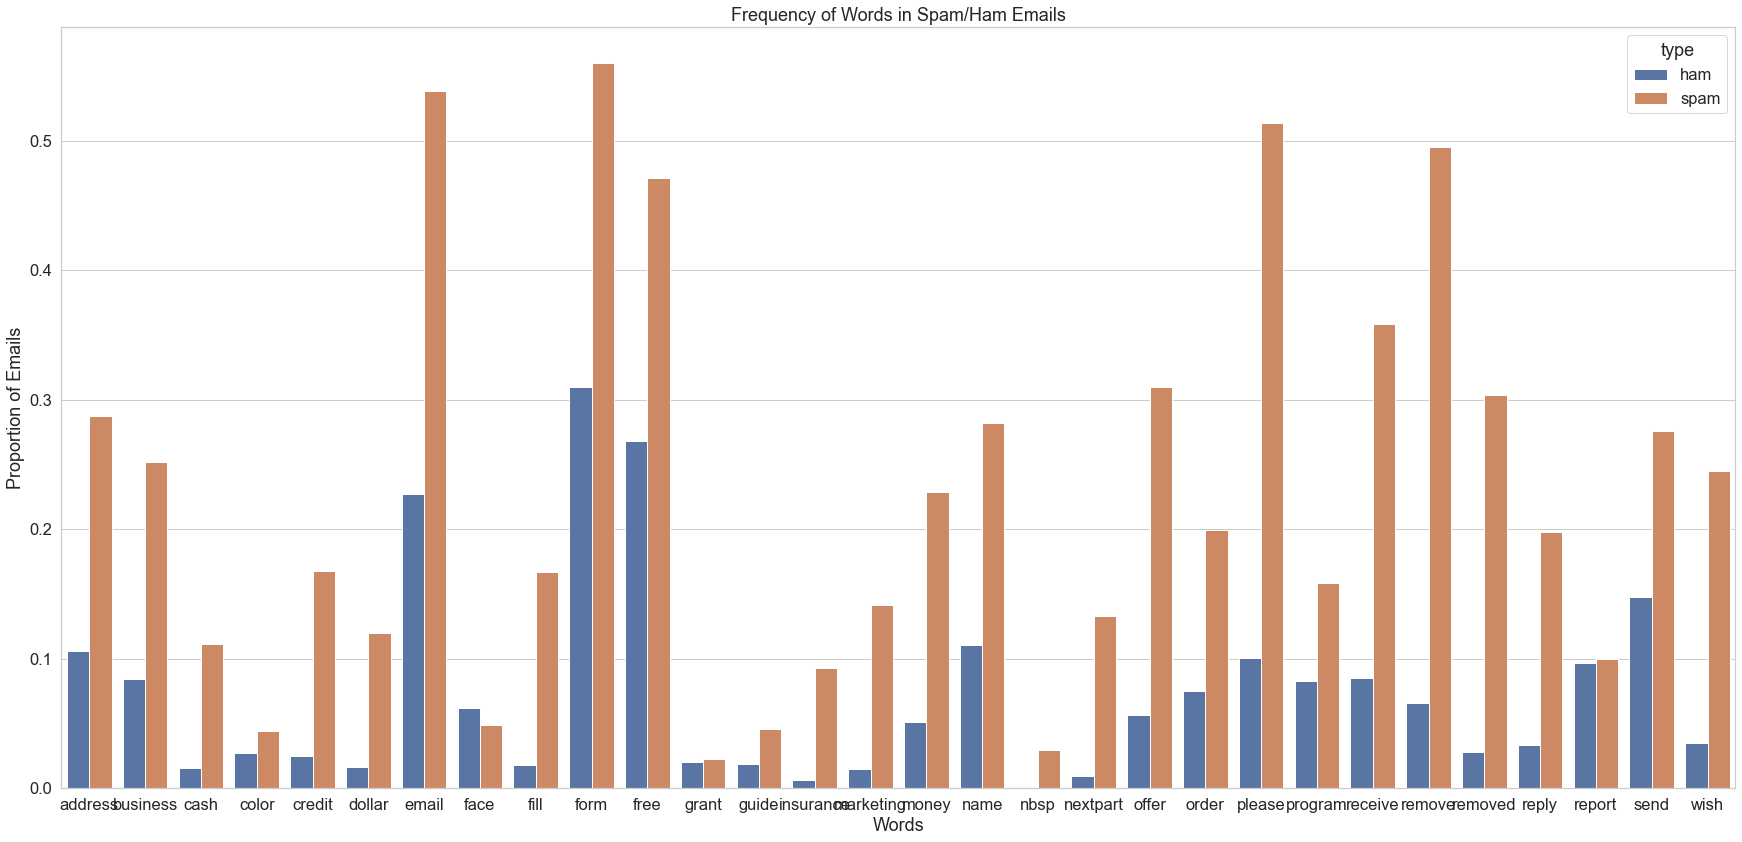

In [137]:
w_c = words_in_texts(words1, train_orig['plain_text'])
df = pd.DataFrame(data = w_c, columns = words1)
df['type'] = train_orig['spam']
df = df.replace({'type': {0: 'ham', 1:'spam'}}).melt('type')
result = df.groupby(['variable', 'type'], as_index = False).mean()

plt.figure(figsize=(30,14))
sns.barplot(x = "variable", y = "value", hue = "type", data = result)
plt.xlabel('Words')
plt.ylabel('Proportion of Emails')
plt.title('Frequency of Words in Spam/Ham Emails')

## PART-IV

### Buiding a Classification Model

In [239]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
ww=freq_word.sort_values(by=0, ascending=False).head(500).index
w_c1 = words_in_texts(ww, train_orig['plain_text'])
df1=pd.DataFrame(data=w_c1, columns=ww)


In [243]:
df2=pd.concat([train_orig.iloc[:, 6:], df1], axis=1)
y=train_vec.iloc[:,0]

X_train,X_test,y_train,y_test, = train_test_split(df2,y,test_size=0.2,random_state=42)
#LOGISTIC REGRESSION
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='liblinear')
lg = model.fit(X_train,y_train)


In [247]:
training_accuracy = logist.score(X_train, y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.9189877208745133


In [248]:
y_pred=lg.predict(X_test)

print("Testing Accuracy: ", accuracy_score(y_test,y_pred))

Testing Accuracy:  0.9568862275449102


In [249]:
## Examine the class distribution of the testing set
y_test.value_counts()

0    1229
1     441
Name: spam, dtype: int64

In [250]:
# calculate the percentage of ones
y_test.mean()

0.26407185628742513

In [251]:
# calculate the percentage of zeros
1-y_test.mean()

0.7359281437125749

In [252]:
# calculate null accuracy in a single line of code
max(y_test.mean(), 1 - y_test.mean())

0.7359281437125749

The above means that a model that always predicts 0 would have a 68% of accuracy, and my classification model with 96% accuracy in the testing set and 92% accuracy in training set is much better

## PART-V

### Evaluting Classifier

### Confusion matrix

In [256]:
confusion = metrics.confusion_matrix(y_test, y_pred)
print(confusion)

[[1213   16]
 [  56  385]]


### Some terminologies:

- **0**: negative class (ham email)
- **1**: positive class (spam email)
- **True Positive (TP)**: I correctly predicted that an email is a spam email
    - 385
- **True Negative (TN)**: I correctly predicted that an email is a ham email
    - 1213
- **False Positive (FP)**: I incorrectly predicted that an email is a spam email
    - 16
    - also called Type I error
- **False Negative (FN)**: I incorrectly predicted that an email is a ham email
    - 56
    - also called Type II error

There are two kinds of errors could be made during model buiding:
* False positive (FP) - "Type I": a ham email gets labeled as spam and filtered out of the inbox.
* False negative (FN) - "Type II": a spam email gets labeled as ham and stays in the inbox.

To be clear, the spam emails are labeled as 1 and the ham emails are as 0. 

There some metrics could be calculated in a classification model to evaluate the mdoel:  

- **Accuracy** measures the proportion $\frac{\text{TP}+\text{TN}}{\text{FP} + \text{TN}+\text{TP}+\text{FN}}$ of how the model correctly labels both ham and spam emails.

- **Error** measures the proportion $\frac{\text{FP}+\text{FN}}{\text{FP} + \text{TN}+\text{TP}+\text{FN}}$ of how the model incorrectly labels both ham and spam emails.

- **Precision** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FP}}$ of emails flagged as spam that are actually spam.

- **Recall** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FN}}$ of actually spam emails that were correctly flagged as spam. (also called "Sensitivity")

- **Specificity** measures the proportion $\frac{\text{TN}}{\text{TN} + \text{FP}}$ of how the model correctly predicted the ham emails.

In this project, I would focus on optimizing for the **precision** or **specificity** to evaluate the model. Because false negatives (spam emails go to the inbox) are better than false positive (ham email is filtered out by the spam filter), which means that some useful emails would not filter out.

In [257]:
#[row, column]
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

**1. Accuracy**

In [259]:
# use float to perform true division, not integer division
print((TP + TN) / float(TP + TN + FP + FN))
print(metrics.accuracy_score(y_test, y_pred))

0.9568862275449102
0.9568862275449102


**2. Precision**: how correctly the model predict a spam email?

In [260]:
precision = TP / float(TP + FP)

print(precision)
print(metrics.precision_score(y_test, y_pred))

0.9600997506234414
0.9600997506234414


**3. Specificity**: How correctly the model predict a ham email?

In [261]:
specificity = TN / (TN + FP)

print(specificity)

0.9869812855980472


### Conclusion:

The three metrics show that the logistic model did a great job in predicting both ham and spam email correctly

## PART-VI

### Next Step
1. Create a ROC curve.
2. Collect more data to test the model.
3. Create another model to test the accuary